## Это файл с решением задания 5

### Вопрос: 
- Напиши функцию на python, позволяющую строить *когортный (семестровый) анализ*.   
- В период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов.

### Общая логика: 
1. Создаем дата-сет с теми студентами, кто сдавал экзамены, поскольку завершаемость и средний срок сдачи подразумевает наличие экзамена на предмете 
2. Если это дата-сет с экзаменами, то мы должны не забывать про студента (из предыдущих заданий), кто не зарегистрировался на экзамен
    - удаление незарегистрированного студента 
    
    Дополнительные вопросы: 
    - покрывает ли date_submitted всех студентов. Иными словами, у всех ли студентов date_submitted != NA 
    - Определиться, какой семестр первее: J или B 
    
3. Из прошлого задания мы помним, что для определения среднего срока нужно использоваться date_submitted (поскольку она самая широкая) 

4. Построение функции для когорного анализа: по среднему сроку и завершаемости с двумя heat_map

### Либы

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

sns.set(rc={'figure.figsize':(10,9)})

### Загрузка дата-сета

In [8]:
#Качаем дата-сеты
assesments = pd.read_csv('/home/jupyter-v-ankushev-18/Project_2_online/assessments.csv')
courses = pd.read_csv('/home/jupyter-v-ankushev-18/Project_2_online/courses.csv')
student_assesment = pd.read_csv('/home/jupyter-v-ankushev-18/Project_2_online/studentAssessment.csv')
student_registration = pd.read_csv('/home/jupyter-v-ankushev-18/Project_2_online/studentRegistration.csv')

#Связываем дата-сеты
courses_reg = pd.merge(courses,student_registration,on=['code_module', 'code_presentation'])
ocenki = pd.merge(courses_reg, assesments,on= ['code_module', 'code_presentation'])
full_ocenki = pd.merge(ocenki, student_assesment,on=['id_assessment', 'id_student'])

### Создаем дата-сет со студентами, которые сдавали экз

In [9]:
#Список критерий
examini = full_ocenki[full_ocenki['assessment_type'] == "Exam"].id_student.unique().tolist()

#Дата-сет с экзаменами
examin_data = full_ocenki[full_ocenki.id_student.isin(examini)]

### Удалим студента
кто не зарегистировался на экзамен, поскольку он не сдал экз –> он его дропнул

In [10]:
#Дропнутый студент
dropped_student = [425543]

#Удаление
examin_data_new = examin_data[~examin_data.id_student.isin(dropped_student)]

### Покрывает ли date_submitted всех студентов? Или есть NA?

In [11]:
examin_data_new.query('date_submitted != date_submitted')

,code_module,code_presentation,module_presentation_length,id_student,date_registration,date_unregistration,id_assessment,assessment_type,date,weight,date_submitted,is_banked,score


Нет, date_submitted покрывает всех студентов!

## Какой из семестров первее J или B?

Я не знаю по каким метрикам определить, какой семестр первее – J или B  
Посмотрел на id_assessment, потому что вроде эта метрика нерандомная. Она имеет закономерное возрастание   
Но там получилась фигня

Так, что давайте договоримся по алфавитному порядку:
* 2013B
* 2013J
* 2014B
* 2014J

## Когортный анализ

In [12]:
#Функция для того, чтобы принтить два результата на одной странице
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [13]:
def cohort_analysis(data_set):
    #Средний срок успешной сдачи экзамена
    avg_srok = data_set.query('score >= 40 & assessment_type == "Exam"') \
    .groupby(['code_module', 'code_presentation'], as_index = False) \
    .agg({'date_submitted' : 'mean'}).round(2)
    
    #Общее количество сдачи экзаменов
    number_split = data_set.query('assessment_type == "Exam" & score == score') \
    .groupby(['code_module', 'code_presentation'])['assessment_type'].value_counts().to_frame() \
    .rename({'assessment_type': 'num'}, axis='columns').reset_index() 
    
    #Кол-во успешной сдачи экзаменов
    success_split = data_set.query('assessment_type == "Exam" & score >= 40 & score == score') \
    .groupby(['code_module', 'code_presentation'])['assessment_type'].value_counts().to_frame() \
    .rename({'assessment_type': 'num'}, axis='columns').reset_index() \
    .rename({'num': 'success'}, axis='columns')
    
    #Соединяем дата-сеты: общее кол-во сдачи экз. & кол-во успешной сдачи экзаменов
    gr_zavershaemost_split = number_split.merge(success_split, on = ['code_module', 'code_presentation', 'assessment_type'])

    #Считаем формулу завершаемости 
    gr_zavershaemost_split['zavershaemost'] = round(gr_zavershaemost_split.success / gr_zavershaemost_split.num,2)
    
    #Удаляем ненужный колонки
    gr_zavershaemost_split.drop(['assessment_type', 'num', 'success'], axis=1, inplace=True)
    
    #Соединяем средний срок успешной сдачи экз и завершаемости
    cohort_data = avg_srok.merge(gr_zavershaemost_split, on = ['code_module', 'code_presentation'])

    #Строим пивот таблицу для среднего срока успешной сдачи
    srok_cohort = cohort_data.pivot_table(index = 'code_module', 
                                     columns = 'code_presentation', 
                                     values = 'date_submitted')

    #Строим пивот таблицу для завершаемости
    zavershaemost_cohort = cohort_data.pivot_table(index = 'code_module', 
                                     columns = 'code_presentation', 
                                     values = 'zavershaemost')
    #Строим график
    fig = plt.figure()
    
    #Распологаем два графика: слева и справа
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    
    #Хитмап для среднего срока успешной сдачи 
    graph_srok = sns.heatmap(srok_cohort, annot = True, fmt = '', ax=ax1)
    
    #Хитмап для завершаемости
    graph_zavershaemost = sns.heatmap(zavershaemost_cohort, annot = True, fmt = '')
    
    #Последовательно отображаем две пивот таблицы 
    print(display_side_by_side(srok_cohort, zavershaemost_cohort, titles=['Средний срок','Завершаемость']))

code_presentation,2013B,2013J,2014B,2014J
code_module,,,,
CCC,NaN,NaN,231.58,244.4
DDD,230.16,239.51,234.94,242.8
code_presentation,2013B,2013J,2014B,2014J
code_module,,,,
CCC,NaN,NaN,0.89,0.87
DDD,0.84,0.91,0.93,0.89


None


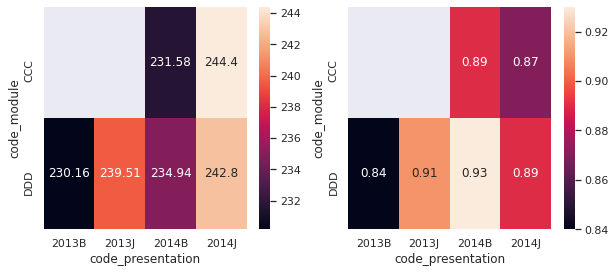

In [14]:
#Применяем функцию
cohort_analysis(examin_data_new)

## Общий ответ на вопрос:

1. Когортный анализ не супер хорошо подходит для этих данных, поскольку:
    - наши студенты не перетекают во все семестры (когортный анализ предполагает это). Т.е. наши студенты не были во всех семестрах и предметах
    - данных мало 
    - вариация маленькая
    
    
2. Нужно посмотреть на когортный анализ по тестам (включая экзы), но условие задания этого не предполагает (да и я уверен, что их наличие не улучшит картину...)


3. Основной вывод: нужно больше данных, чтобы хорошо описать когорты! А лучше предложить иной анализ / иные метрики... 